### Importy bibliotek

In [34]:
import json
import string
# import morfeusz2
import pandas as pd
import itertools as it
from wordcloud import WordCloud
import operator as op
from nltk.corpus import PlaintextCorpusReader
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from matplotlib import pyplot as plt
import os
from sklearn.decomposition import LatentDirichletAllocation, NMF


1. Utworzenie korpusu dokumentów

In [35]:
corpus_dir = "./literatura"
corpus = PlaintextCorpusReader(corpus_dir, ".*\.txt")
files = corpus.fileids()
files

<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:2: SyntaxWarning: invalid escape sequence '\.'
/var/folders/4v/mdq8tns56dj56v4326133v3w0000gq/T/ipykernel_23407/3713825801.py:2: SyntaxWarning: invalid escape sequence '\.'
  corpus = PlaintextCorpusReader(corpus_dir, ".*\.txt")


['Harry Potter i Czara Ognia.txt',
 'Harry Potter i Insygnia Smierci.txt',
 'Harry Potter i Kamien Filozoficzny.txt',
 'Harry Potter i Komnata Tajemnic.txt',
 'Harry Potter i Ksiaze Polkrwi.txt',
 'Harry Potter i Przeklete Dziecko.txt',
 'Harry Potter i Wiezien Azkabanu.txt',
 'Harry Potter i Zakon Feniksa.txt',
 'Opowiesci z Narni. Kon i jego chlopiec.txt',
 'Opowiesci z Narni. Ksiaze Kaspian.txt',
 'Opowiesci z Narni. Lew, czarownica i stara szafa.txt',
 'Opowiesci z Narni. Ostatnia bitwa.txt',
 'Opowiesci z Narni. Podroz Wedrowca do Switu.txt',
 'Opowiesci z Narni. Siostrzeniec Czarodzieja.txt',
 'Opowiesci z Narni. Srebrne krzeslo.txt',
 'Zmierzch.Ksiezyc w Nowiu.txt',
 'Zmierzch.Przed Switem.txt',
 'Zmierzch.Zacmienie.txt',
 'Zmierzch.Zmierzch.txt',
 'Zmierzch.Zycie i Smierc.txt']

2. Wstęne przygotowanie dokumentów

In [36]:
documents = {}
for  f in files:
    documents[f] = corpus.raw(f)
print(json.dumps(documents, indent=4, ensure_ascii=False))    

{
    "Harry Potter i Czara Ognia.txt": "Lord Voldemort, wraz ze swoim sługą Glizdogonem przybywa do domu należącego niegdyś do rodziny Riddle'ów położonego w Little Hangleton. Tam układają plan dotyczący zamordowania Harry'ego Pottera, co ma pomóc Czarnemu Panu w odzyskaniu jego dawnej mocy. Jest także mowa o wiernym słudze Czarnego Pana, który wkrótce ma znaleźć się w Hogwarcie. Wszystko to słyszy mieszkający nieopodal ogrodnik, Frank Bryce. Voldemort odkrywając, iż mężczyzna podsłuchuje, zaprasza go do środka i uśmierca. Harry budzi się z przerażającego snu. Jego blizna pulsuje okropnym bólem. Próbuje sobie przypomnieć o czym śnił, a z pamięci wyłania się obraz mrocznego pokoju, węża leżącego przed kominkiem oraz Glizdogona i Lorda Voldemorta planujących morderstwo. Harry zastanawia się czy powinien komuś powiedzieć o problemach z blizną, ponieważ, gdy bolała go ostatnim razem, Voldemort wdarł się do Hogwartu. Ostatecznie postanawia napisać do Syriusza i zejść na śniadanie. W trakci

In [37]:
stoplist_file = open("./stopwords_pl.txt", "r", encoding="UTF-8")
stoplist = stoplist_file.read().splitlines()
stoplist_file.close()
stoplist = stoplist[4:]
stoplist

['vol',
 'o.o.',
 'mgr',
 'godz',
 'zł',
 'www',
 'pl',
 'ul',
 'tel',
 'hab',
 'prof',
 'inż',
 'dr',
 'i',
 'u',
 'aby',
 'albo',
 'ale',
 'ani',
 'aż',
 'bardzo',
 'bez',
 'bo',
 'bowiem',
 'by',
 'byli',
 'bym',
 'był',
 'była',
 'było',
 'były',
 'być',
 'będzie',
 'będą',
 'chce',
 'choć',
 'co',
 'coraz',
 'coś',
 'czy',
 'czyli',
 'często',
 'dla',
 'do',
 'gdy',
 'gdyby',
 'gdyż',
 'gdzie',
 'go',
 'ich',
 'im',
 'inne',
 'iż',
 'ja',
 'jak',
 'jakie',
 'jako',
 'je',
 'jednak',
 'jednym',
 'jedynie',
 'jego',
 'jej',
 'jest',
 'jeszcze',
 'jeśli',
 'jeżeli',
 'już',
 'ją',
 'kiedy',
 'kilku',
 'kto',
 'która',
 'które',
 'którego',
 'której',
 'który',
 'których',
 'którym',
 'którzy',
 'lat',
 'lecz',
 'lub',
 'ma',
 'mają',
 'mamy',
 'mi',
 'miał',
 'mimo',
 'mnie',
 'mogą',
 'może',
 'można',
 'mu',
 'musi',
 'na',
 'nad',
 'nam',
 'nas',
 'nawet',
 'nic',
 'nich',
 'nie',
 'niej',
 'nim',
 'niż',
 'no',
 'nowe',
 'np',
 'nr',
 'o',
 'od',
 'ok',
 'on',
 'one',
 'oraz',
 '

In [38]:
def lemmatize(text):
    morf = morfeusz2.Morfeusz()
    segments = it.groupby(morf.analyse(text), op.itemgetter(0,1))
    def disambiguate(group):
        pairs = ((len(descr), lemma)
                 for _, _, (_, lemma, descr, _, _, ) in group)
        perpl, lemma = min(pairs)
        return lemma.split(":")[0]
    lemmas = (disambiguate(group) for key, group in segments)
    return " ".join(filter(str.isalpha, lemmas))

In [39]:
for key in documents:
    documents[key] = documents[key].lower()
    documents[key] = "".join([char for char in documents[key] if char not in string.punctuation])
    documents[key] = lemmatize(documents[key])
    documents[key] = " ".join([word for word in word_tokenize(documents[key], language='polish') if word not in stoplist])

    print(json.dumps(documents, indent=4, ensure_ascii=False))

NameError: name 'morfeusz2' is not defined

### 3. Utworzenie macierzy częstości

In [ ]:
docs = pd.DataFrame.from_dict(documents, orient='index')
docs.columns = ['content']
docs

,content
Harry Potter i Czara Ognia.txt,lord voldemort wraz ze swoim sługą glizdogonem...
Harry Potter i Insygnia Smierci.txt,"Podczas zebrania śmierciożerców, które odbywa ..."
Harry Potter i Kamien Filozoficzny.txt,Na ulicy Privet Drive pojawia się stary człowi...
Harry Potter i Komnata Tajemnic.txt,"Wuj Vernon jest zły, że Hedwiga robi bałagan w..."
Harry Potter i Ksiaze Polkrwi.txt,Mugolskiego premiera odwiedza Korneliusz Knot ...
Harry Potter i Przeklete Dziecko.txt,"Scena pierwsza oraz druga opowiada historię, k..."
Harry Potter i Wiezien Azkabanu.txt,Harry leży pod kocami w łóżku i odrabia prace ...
Harry Potter i Zakon Feniksa.txt,Dudley jest zły i wyżywa się na Harrym. Dudley...
Opowiesci z Narni. Kon i jego chlopiec.txt,Akcja książki rozgrywa się w Narnii za czasów ...
Opowiesci z Narni. Ksiaze Kaspian.txt,"Mija rok od wydarzeń opisanych w powieści ""Lew..."


In [ ]:
count_vectorizer = CountVectorizer()
counts_tf = count_vectorizer.fit_transform(docs['content'])
counts_tf.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(20, 7485))

In [ ]:
tfidfcount_vectorizer = TfidfVectorizer()
counts_tfidf = tfidfcount_vectorizer.fit_transform(docs['content'])
counts_tfidf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01353591, 0.01706547, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(20, 7485))

### 4. Chmury tagów

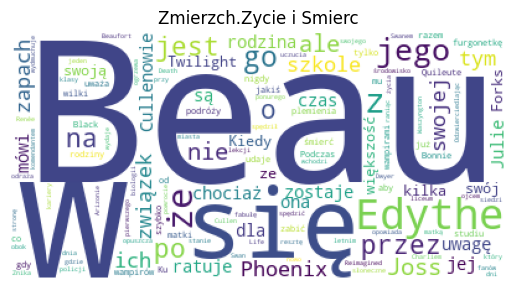

In [ ]:
wordcloud = WordCloud(
    background_color='white',
    max_words=5000,
    contour_width=3,
    contour_color='steelblue'
)
if not os.path.exists("./chmury"):
    os.mkdir("./chmury")
for index, row in docs.iterrows():
    wordcloud.generate(row['content'])
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(index.replace(".txt", ""))
    plt.savefig("./chmury/{}".format(index.replace(".txt", ".png")))

In [ ]:
if not os.path.exists("./tematy"):
    os.mkdir("./tematy")
def plot_top_words(model, feature_names, n_top_words, title, subplots):
    fig, axes = plt.subplots(*subplots, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.savefig(f"./tematy/{title}.png")

In [ ]:
n_components = 6
feature_names = count_vectorizer.get_feature_names_out()
n_top_words = 20
subplots = (2,3)

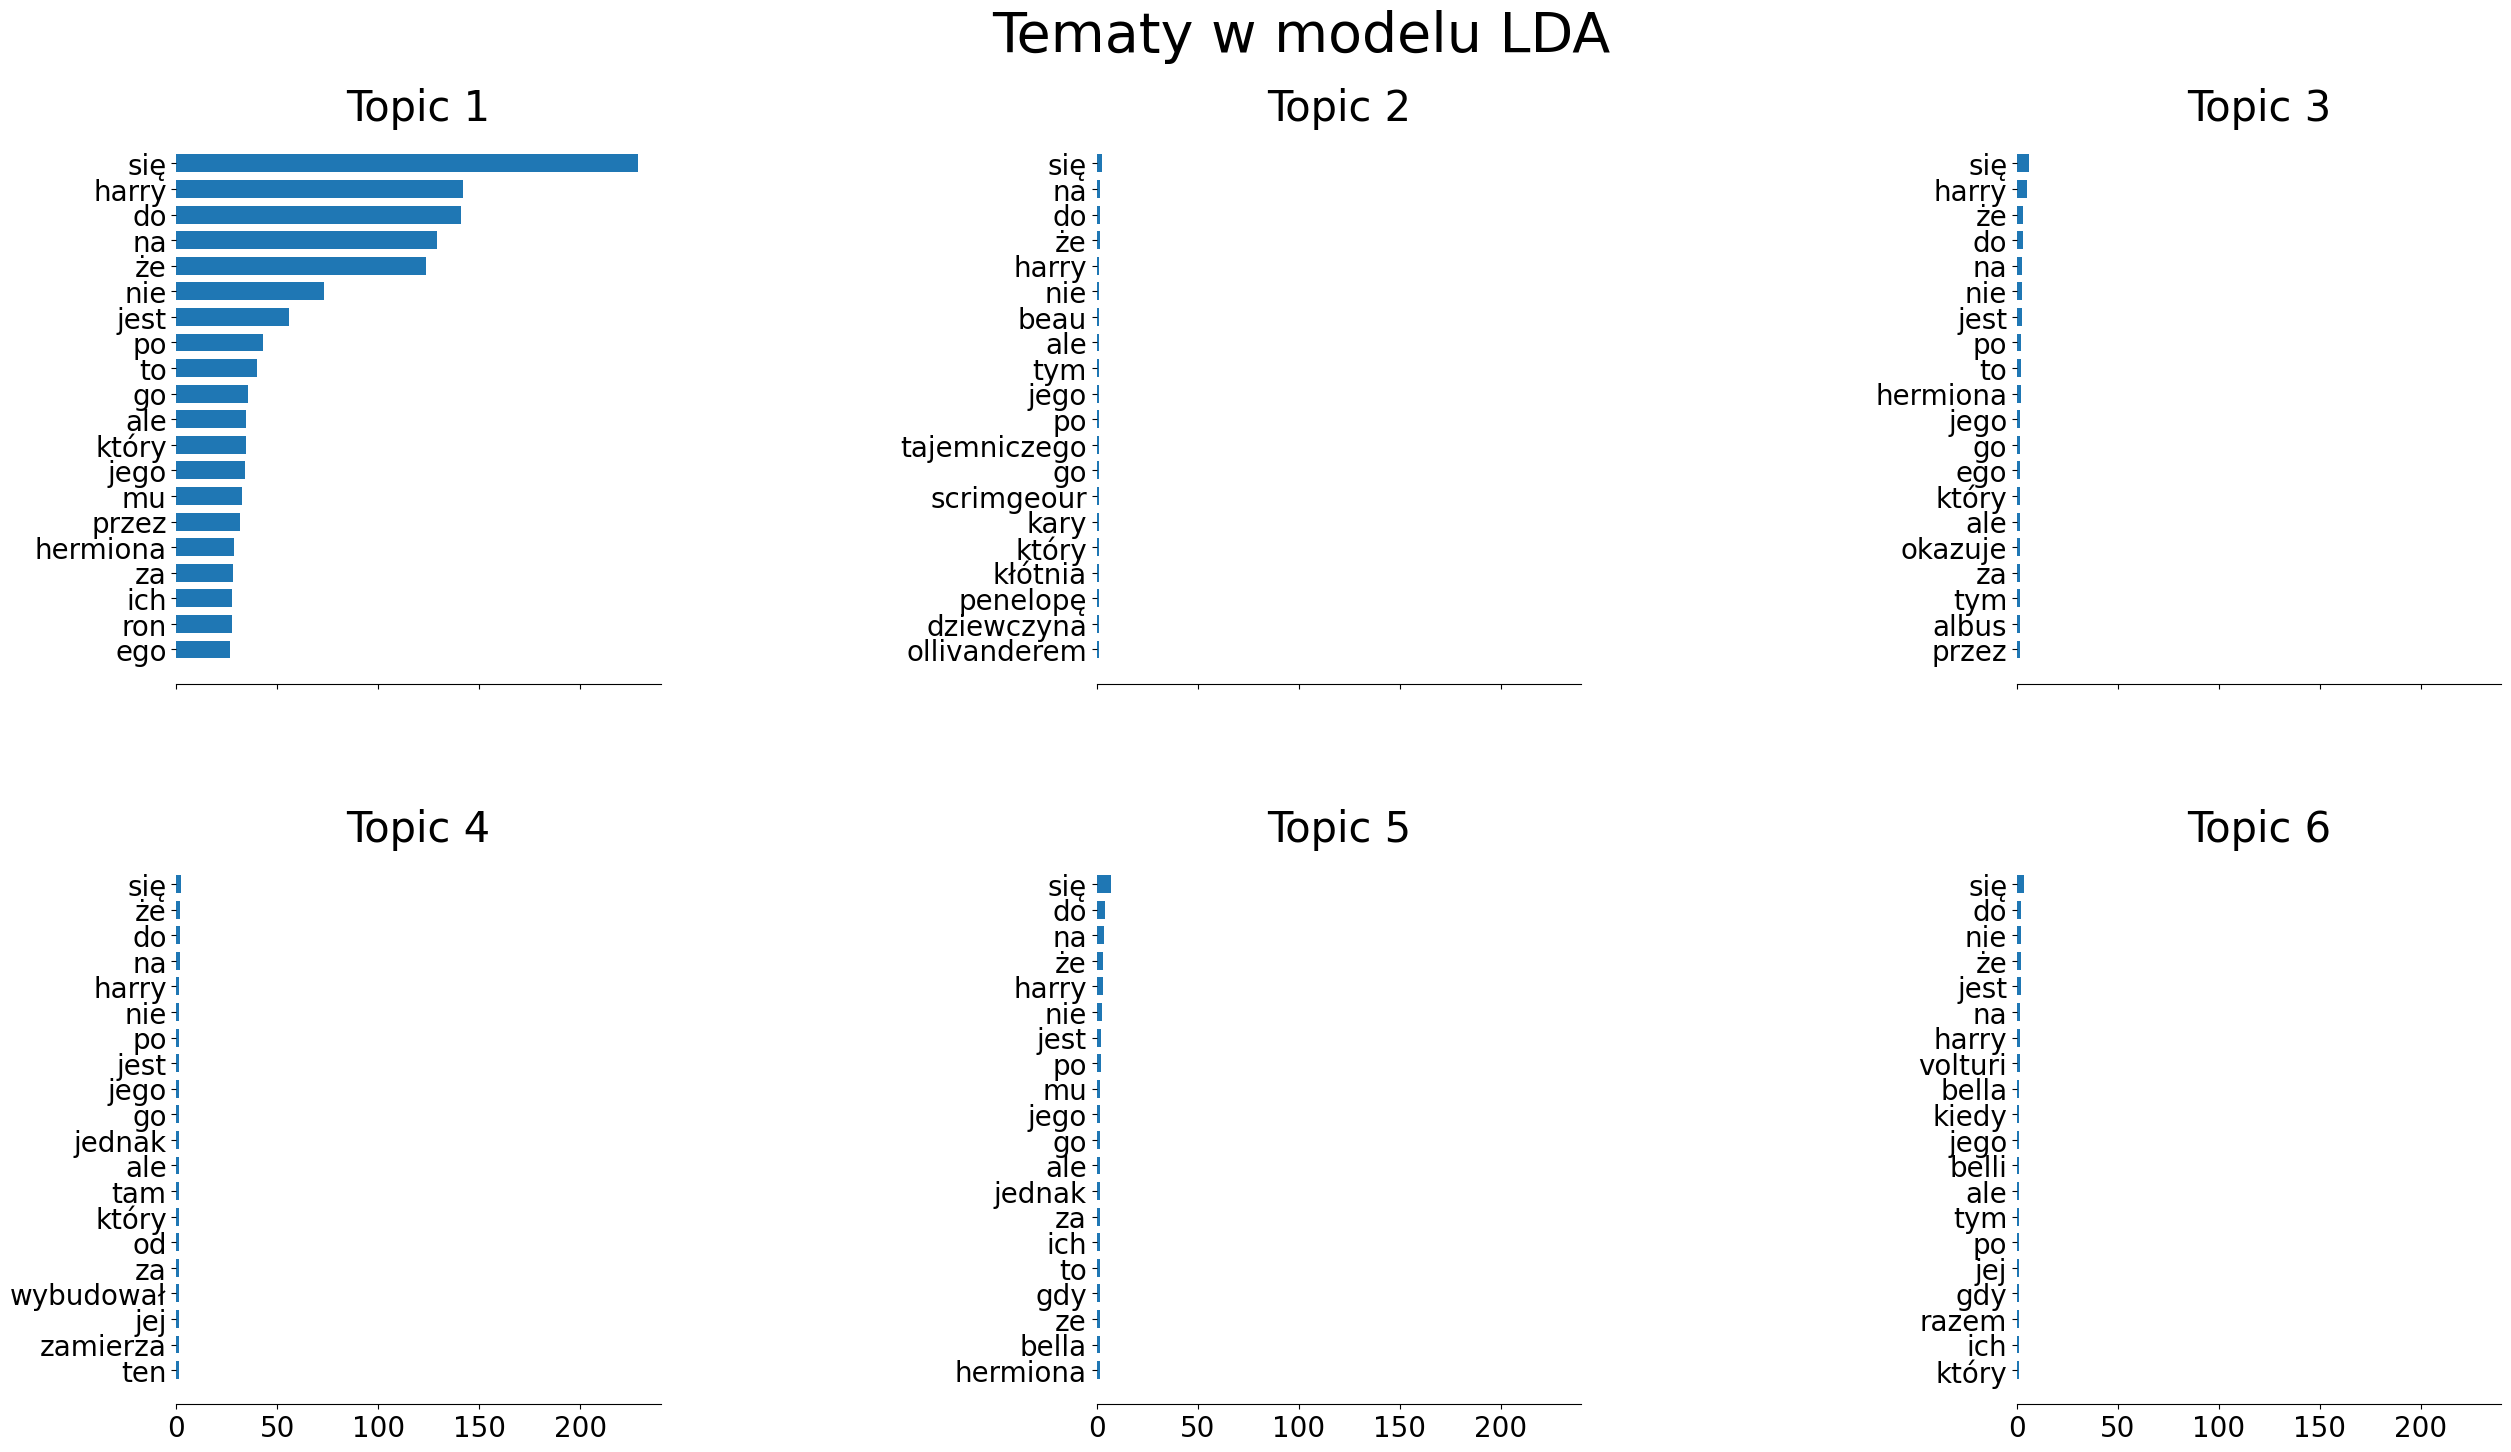

In [ ]:
lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method='online',
    learning_offset=50,
    random_state=0
)
lda.fit(counts_tf)
plot_top_words(lda, feature_names, n_top_words, "Tematy w modelu LDA", subplots)

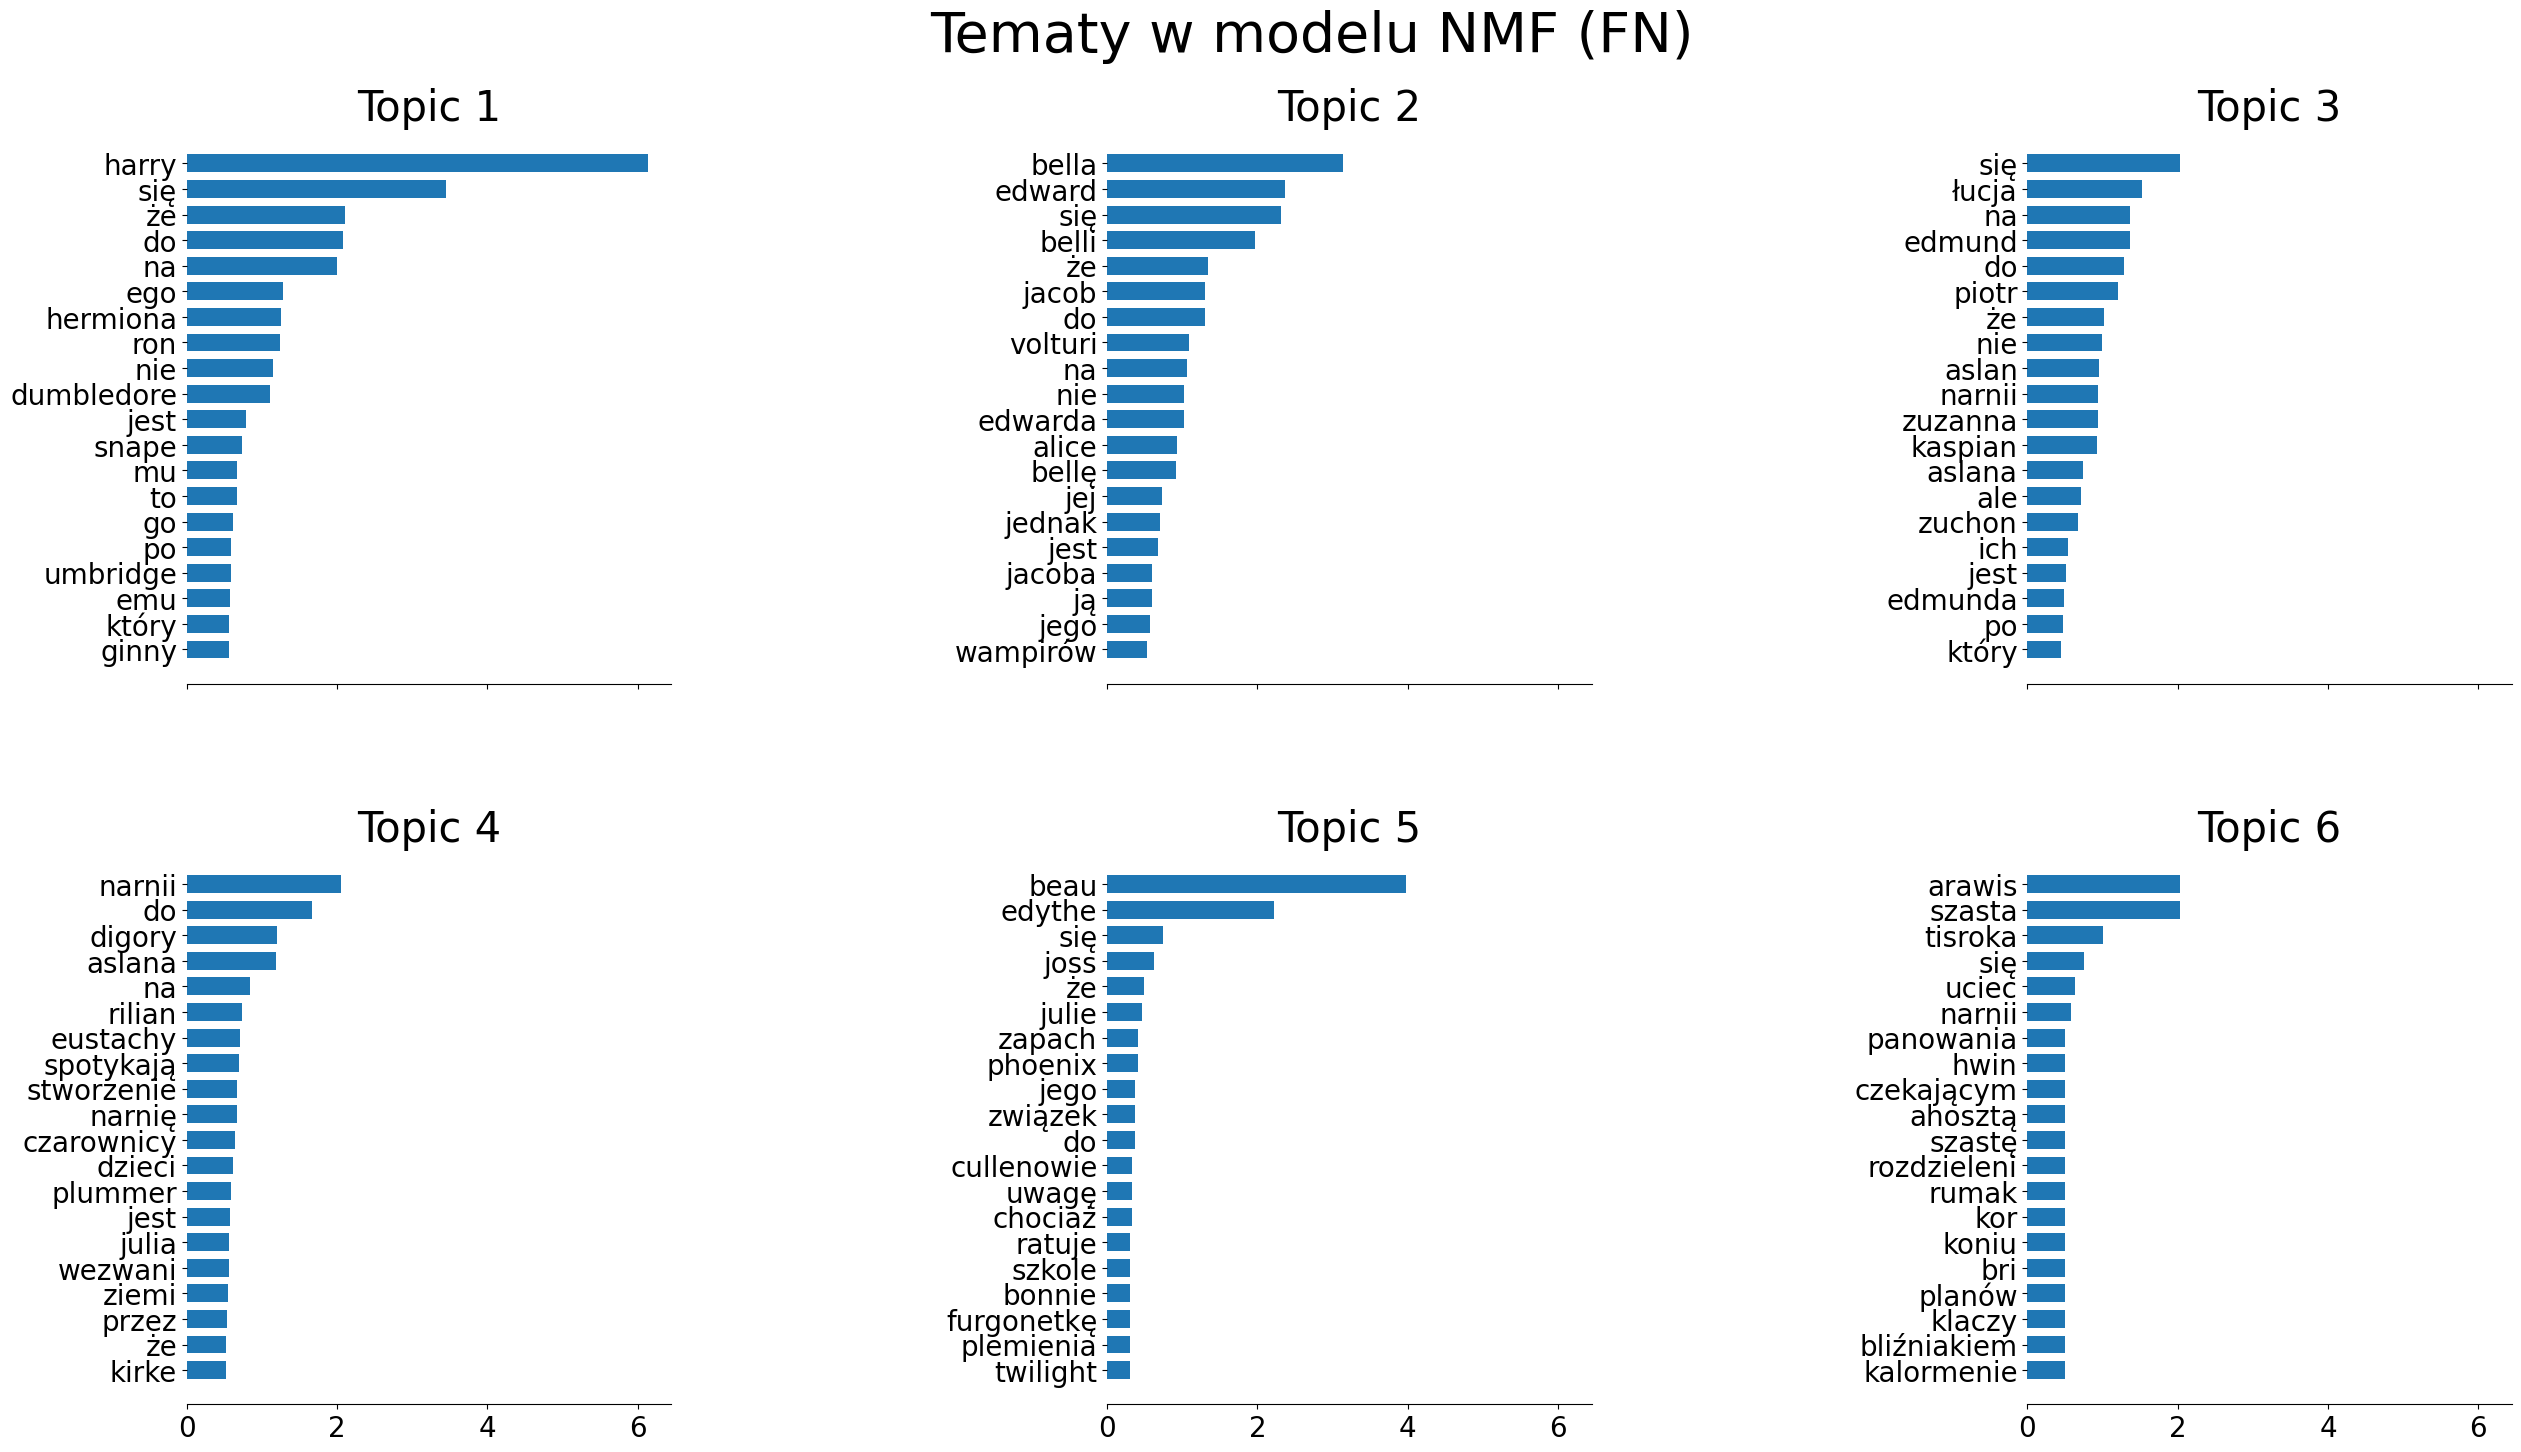

In [ ]:
nmf_fn = NMF(
    n_components=n_components,
    random_state=1,
    alpha_H=.00005,
    alpha_W=.00005,
    l1_ratio=.5
)
nmf_fn.fit(counts_tfidf)
plot_top_words(nmf_fn, feature_names, n_top_words, "Tematy w modelu NMF (FN)", subplots)

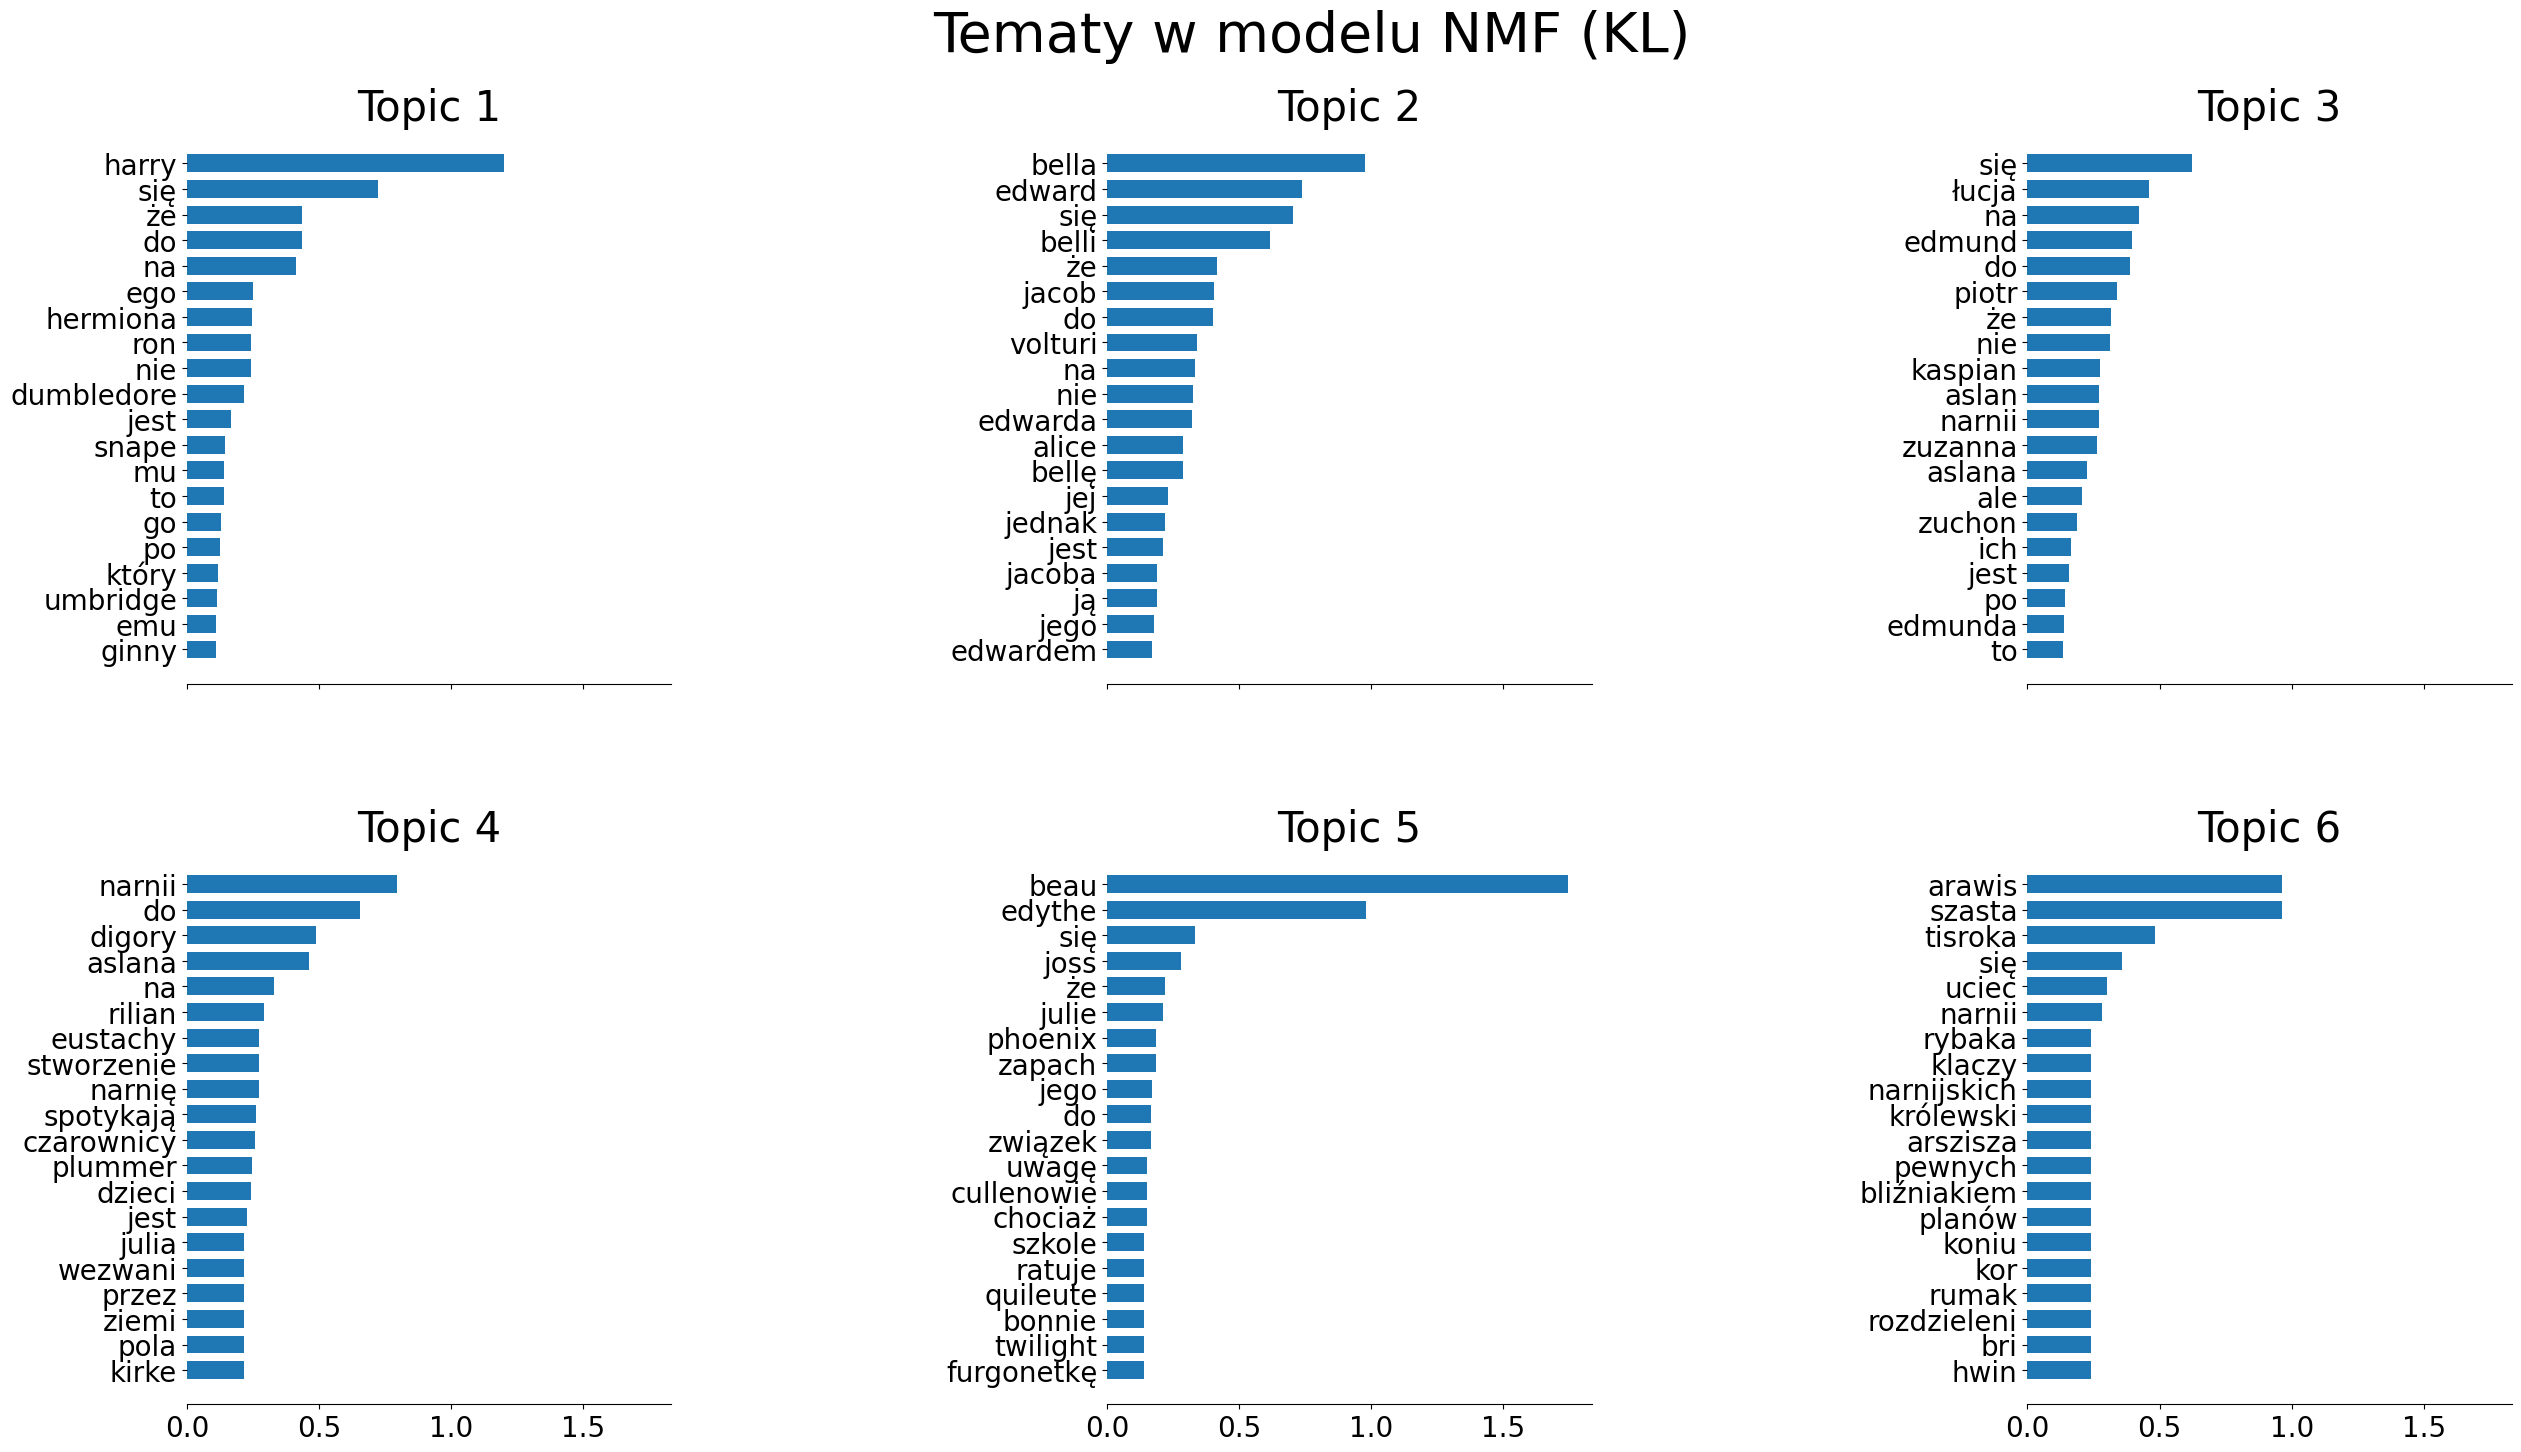

In [40]:
nmf_kl = NMF(
    n_components=n_components,
    random_state=1,
    beta_loss='kullback-leibler',
    solver='mu',
    max_iter=1000,
    alpha_H=.00005,
    alpha_W=.00005,
    l1_ratio=.5
)
nmf_kl.fit(counts_tfidf)
plot_top_words(nmf_kl, feature_names, n_top_words, "Tematy w modelu NMF (KL)", subplots)